# Constructing synthetic data

In [4]:
from numpy.random import normal
import numpy as np
np.random.seed(0)
rng = np.random.RandomState(10)
import scipy.stats
import math
import collections
import pandas as pd
from tqdm import tqdm, tqdm_notebook

In [5]:
# Random alternative specific coefficients: 
N = 1000
J = 12  # alternatives
T = 10 # Choice situations
extras = 0
K_b = 2  + extras# variables
K_a = J - 1
K = K_b + K_a
mean = np.zeros((N,T,J,K_b- extras))
variance = np.identity(K_b- extras)*2 
X_b = normal(mean, 1)
X_a = np.zeros((N,T,J,K_a))

for i in range(K_a):
    print(i+1)
    X_a[:,:,i+1,i] = 1
X = np.concatenate((X_a,X_b),axis=3)

X.shape # N*T*J*K

## Simulating som mixed logit data:
# U = deterministic part + random part


# Random coefficients
# Coefficients drawn from a normal: 
# Priors
b = normal(0,1,K_b)
b_true_coeff = b


B = np.identity(K_b)*1 #+ np.diag((2,1))
B[0,0] = 2


U = np.zeros((N,T,J))
#U_t = U

# Beta coefficients
#coeff=np.random.multivariate_normal(b,B, size = N) 
coeff=rng.multivariate_normal(b,B, size = N) 

# alpha 
alpha = normal(0,1,K_a)
a_true = alpha





b_true = np.mean(coeff, axis = 0)
B_true=np.cov(coeff,rowvar=False)

# This step attempts to recreate the no identification problems that i'm experiencing
var = np.zeros(J)
var[0] = 1
#var[0] = 1

var = np.repeat(var[None,:],N,axis=0)
var = np.repeat(var[:,None,:],T,axis=1)

#X = np.concatenate((X,var[:,:,:,None]),axis=3)

gumb = rng.gumbel(size = (N,T,J))
for n in range(N): 
    for t in range(T):
        U_n=X[n,t,:].dot(np.concatenate((alpha,coeff[n,:])).T) + gumb[n,t,:] 
        U[n,t,:] = U_n   

Y = np.argmax(U,axis = 2)

unique, counts = np.unique(Y, return_counts=True)
counts

1
2
3
4
5
6
7
8
9
10
11


array([ 843,  602, 1294,  806,  415,  877,  575,  995, 2165,  274,  446,
        708])

In [6]:
X.shape # N*T*J*K I will reshape this into a NTJ*1
X_t = X.reshape((N*T*J,K))
user = np.repeat(range(N),T*J) # I make an index that is supposed to look as if a user index existed
Y_t = Y.reshape(N*T)
Y_tt = Y_t.repeat(J)
#beta_N.shape
Y_tt 
index=np.tile(range(J),N*T)
y_index=np.where(np.equal(Y_tt,index).astype(int))[0]

mask = np.ones(index.size, dtype=bool)
mask[y_index] = 0
y_nindex = np.where(mask)[0]
y_nindex

np.array([user,index]).T
list_users=user[y_index]
users=list(collections.Counter(user).values())
NT = N*T

X_t=X_t.astype(float)
count_users = np.cumsum(np.unique(list_users, return_counts=True)[1])
count_users

array([   10,    20,    30,    40,    50,    60,    70,    80,    90,
         100,   110,   120,   130,   140,   150,   160,   170,   180,
         190,   200,   210,   220,   230,   240,   250,   260,   270,
         280,   290,   300,   310,   320,   330,   340,   350,   360,
         370,   380,   390,   400,   410,   420,   430,   440,   450,
         460,   470,   480,   490,   500,   510,   520,   530,   540,
         550,   560,   570,   580,   590,   600,   610,   620,   630,
         640,   650,   660,   670,   680,   690,   700,   710,   720,
         730,   740,   750,   760,   770,   780,   790,   800,   810,
         820,   830,   840,   850,   860,   870,   880,   890,   900,
         910,   920,   930,   940,   950,   960,   970,   980,   990,
        1000,  1010,  1020,  1030,  1040,  1050,  1060,  1070,  1080,
        1090,  1100,  1110,  1120,  1130,  1140,  1150,  1160,  1170,
        1180,  1190,  1200,  1210,  1220,  1230,  1240,  1250,  1260,
        1270,  1280,

### The sampler

In [7]:
## Building a beta draw

from numpy.random import multivariate_normal as MVNrnd

def b_posterior(b_mean, W):
    def normal_draw(mean, cov, check_valid = "raise"):
        return MVNrnd(mean,cov)
    return normal_draw(b_mean,W)

In [8]:
def posterior_W_v2(b, beta_N):
    # Beta_N: N*K matrix
    N = beta_N.shape[0]
    K = beta_N.shape[1]

    beta = beta_N - b
    S_bar = np.einsum('ni,nj->ij',beta, beta)/N
    dof = K+N
    scale_matrix = (K*np.identity(K)+N*S_bar)/(K+N)

    # step 1
    phi=normal(0,1, dof)
    # step 2
    L = np.linalg.cholesky(np.linalg.inv(scale_matrix))

    vector=phi[:,None,None] * L
    R=np.einsum('tni,tnj->ij',vector, vector)/dof
    
    return np.linalg.inv(R)


In [9]:
beta_N = np.ones((696,K))*0.01

In [11]:
A_u, A_c=np.unique(list_users,return_counts = True)
def reshape(A_u,A_c):
    k = 0
    t = 0
    put_list = []
    set_list = []
    p= np.ones((A_u.size,np.max(A_c)))
    for i in range(A_u.size):
        for j in range(np.max(A_c)):
            if j <= A_c[i]-1:
                #p[i,j] = B[k]
                set_list.append(t)
                k += 1
            t += 1
    return set_list, np.max(A_c)

index, t_max = reshape(A_u,A_c)

def density_pdf(mean, cov, beta):
    return scipy.stats.multivariate_normal(mean, cov).pdf(beta)

# a potential speed up might be possible by dividing data into two parts and then do
# the relatively simple calculations of alpha on a smaller set. 
def softmax_likelihood_v5(data, y_index, y_nindex, beta, users, N, NT, J, t_max, index):
    # construct N*T*K betas by repeating betas
    betas = np.repeat(beta, users, axis = 0)
    mu = np.exp(np.einsum('nj,nj->n',data,betas))
    denom = mu[y_index] # NT 
        
    # I'm worried the num is not returning correct values.
    num = np.sum(mu[y_nindex].reshape(NT,J-1),axis=1) + denom # NT*J -> NT
    sm_scores = denom / num
    # alternative approach: 
    test = np.ones(N*t_max)
    np.put(test, index, sm_scores)
    test = test.reshape((N,t_max))
    test = np.prod(test, axis= 1)
    return test

#%timeit test1 = softmax_likelihood_v5(X_t, y_index, y_nindex, beta_N, users, N, NT, J, t_max, index)

In [13]:
def metropolis_step_beta(data, y_index, y_nindex, alpha_0, beta_0, b, W, rho, users, N, NT, J, t_max, index, F0=None, a_upd=0):
        
    K=beta_0.shape[1]
    N=beta_0.shape[0]
    L = np.linalg.cholesky(W) # Cholesky factor of W
    eta = normal(0,1,(N,K)) #stacked vector of standard normal draws
    #print(eta.shape)
    #print(beta_N.shape)
    
    # This is a bit slow but I cannot find a better way to do it
    alpha = np.repeat(alpha_0[None,:], N,axis=0)
    
    # trial value:
    beta_1_proposal = beta_0 + rho*eta.dot(L)

    # Draw a standard uniform variable: 
    threshold = np.random.uniform(0,1,N)

    # merge coefficients together
    ab1_proposal = np.concatenate((alpha, beta_1_proposal),axis=1)
    ab0 = np.concatenate((alpha, beta_0),axis=1)
    
    # Calculate ratio:
    #data, y_index, y_nindex, beta, users, N, NT, J, t_max, index
    F1 = softmax_likelihood_v5(data, y_index, y_nindex, ab1_proposal, users, N, NT,J, t_max, index)*density_pdf(b, W, beta_1_proposal)
    if a_upd == 1:
        F0 = softmax_likelihood_v5(data, y_index, y_nindex, ab0, users, N, NT,J, t_max, index)*density_pdf(b, W, beta_0)
    F = F1/F0
    
    # accept/reject
    
    cond = np.where(threshold<F,1,0)#beta_0[],beta_1_proposal[:])
    #acc_rate= np.sum(cond) / len(cond)
    F_next = np.where(cond==1,F1,F0)

    acc_rate= np.sum(cond) / cond.size

    beta_1 = np.array([ b1 if c == 1 else b0 for b1,b0,c in zip(beta_1_proposal, beta_0, cond) ])
    
    return beta_1, acc_rate, F_next

#%timeit metropolis_step_beta(X_t, y_index, y_nindex, alpha, beta_N, b, W, rho, users, N, NT, J, t_max, index, None, 1)

In [15]:
def metropolis_step_alpha(data, y_index, y_nindex, alpha_0, beta_0, rho, users, N, NT, J, t_max, index, F0=None):
    K=alpha_0.shape[0]
    N=beta_0.shape[0]
    #L = np.linalg.cholesky(W) # Cholesky factor of W

    eta = normal(0,1,K) #stacked vector of standard normal draws
    #print(eta.shape)
    #print(beta_N.shape)
    
    # trial value:
    alpha_1p = alpha_0 + rho*eta

    
    # This is a bit slow but I cannot find a better way to do it
    alpha = np.repeat(alpha_0[None,:], N,axis=0)
    alpha_1_proposal = np.repeat(alpha_1p[None,:], N,axis=0)

    # Draw a standard uniform variable: 
    threshold = np.random.uniform(0,1)
    
    # stacking coefficients together:
    
    ab1_proposal = np.concatenate((alpha_1_proposal, beta_0),axis=1)
    ab0 = np.concatenate((alpha, beta_0), axis=1)
    
    
    # Calculate ratio:
    F1 = softmax_likelihood_v5(data, y_index, y_nindex, ab1_proposal, users, N, NT, J, t_max, index)
    #if F0 is None:
    F0 = softmax_likelihood_v5(data, y_index, y_nindex, ab0, users, N, NT, J, t_max, index)
    
    F = np.prod(F1/F0)
    
    # accept/reject
    
    cond = np.where(threshold<F,1,0)#beta_0[],beta_1_proposal[:])
    #acc_rate= np.sum(cond) / len(cond)
    #F_next = F1 if cond == 1 else F0
    acc_rate= np.sum(cond) / cond.size

    alpha_1 = np.array(alpha_1p if cond == 1 else alpha_0)
    return alpha_1, acc_rate, cond

#metropolis_step_alpha(X_t, y_index, y_nindex, alpha, beta_N, rho, users, N, NT, J, t_max, index)[0]

## Running the sampler:

In [16]:
from  tqdm import tqdm
## Building a sampler: 
reps = 3000

#N = df.user.nunique()
#K = X_t.shape[1]
#J = df.c_index_h.nunique()

trim = 1
#starting values:
b = np.zeros(K_b)
alpha = np.random.random(K_a)
#alpha = a_true
#b = b_stor[-1,:]
#b = b_true
W = np.identity(K_b)*1 + 0.5 #np.array([[2,1,1],[1,2,1],[1,1,2]])*100
W[0,0] = 1


#W = B
#W[np.triu_indices(5)]=W_stor[-1,:]
#W[np.tril_indices(5)]=W_stor[-1,:]


beta_N = np.random.multivariate_normal(b, W, size = N)

#beta_N = beta_stor[:,:,-1]


# 
acc_rate_g = 0.3
rho_b = .5
rho_a = 0.1
F_a, F_b, a_upd = None, None, 1

# Disabling parts of the sampler
#beta_N = coeff
#b = b_true
#W = B
#beta_N = coeff
# Sampling:
b_stor = np.zeros((int(reps/trim),K_b))
a_stor = np.zeros((int(reps/trim),K_a))
W_stor = np.zeros((int(reps/trim),sum(range(K_b+1))))
beta_stor = np.zeros((N,K_b,int(reps/trim)))
alpha_stor = np.zeros((K_a,int(reps/trim)))
acc_stor = np.zeros((2,int(reps/trim)))

for t in tqdm_notebook(range(reps)):
    
    #print(beta_N.shape)
    b_mean = np.mean(beta_N, axis=0)
    #print(b_mean.shape)
    
    b = b_posterior(b_mean, W/N)
    #print(b)
    
    W = posterior_W_v2(b, beta_N)
    #print(W)
    beta_N, acc_rate_b, F_b = metropolis_step_beta(X_t, y_index, y_nindex, alpha, beta_N, b, W, rho_b, users, N,NT, J,t_max, index, F_b, a_upd)
    
    alpha, acc_rate_a, a_upd = metropolis_step_alpha(X_t, y_index, y_nindex, alpha, beta_N, rho_a, users, N, NT, J, t_max, index, F_a)
    
    

    
    # Storing the values
    if t % trim == 0:
        b_stor[int(t/trim)] = b
        W_stor[int(t/trim)] = W[np.triu_indices(K_b)]
        beta_stor[:,:,int(t/trim)] = beta_N
        alpha_stor[:,int(t/trim)] = alpha
        acc_stor[:,int(t/trim)] = acc_rate_b, acc_rate_a


    # Updating the acc_rate
    if acc_rate_b < acc_rate_g:
        rho_b = rho_b - 0.02 #(acc_rate - acc_rate_g)
    if acc_rate_b > acc_rate_g:
        rho_b = rho_b + 0.02 #(acc_rate - acc_rate_g)

    # updating after 100 iterations:
    if t % 100 == 0: 
        eva = np.mean(acc_stor[1,t-100:t])
        print(eva, rho_a)
        if eva < acc_rate_g:
            rho_a = rho_a - 0.01#*(eva - acc_rate_g)/acc_rate_g
        if eva > acc_rate_g:
            rho_a = rho_a + 0.01#*(eva - acc_rate_g)/acc_rate_g #(acc_rate - acc_rate_g)
        

    #print(beta_N[n,:])

        

    

HBox(children=(IntProgress(value=0, max=3000), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan 0.1
0.33 0.1
0.15 0.11
0.05 0.1
0.06 0.09000000000000001
0.02 0.08000000000000002
0.03 0.07000000000000002
0.01 0.06000000000000002
0.09 0.05000000000000002
0.14 0.040000000000000015
0.26 0.030000000000000013
0.5 0.02000000000000001
0.3 0.030000000000000013
0.16 0.030000000000000013
0.34 0.02000000000000001
0.3 0.030000000000000013
0.29 0.030000000000000013
0.39 0.02000000000000001
0.27 0.030000000000000013
0.46 0.02000000000000001
0.39 0.030000000000000013
0.14 0.040000000000000015
0.27 0.030000000000000013
0.49 0.02000000000000001
0.3 0.030000000000000013
0.36 0.030000000000000013
0.11 0.040000000000000015
0.3 0.030000000000000013
0.28 0.030000000000000013
0.46 0.02000000000000001



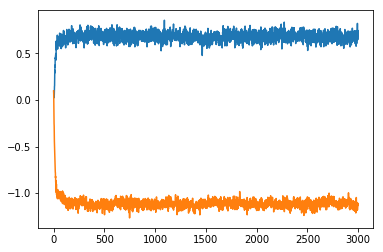

['dist', 'at_campus', 'os_mm', 'G_ratings', 'G_price']
[ 0.67920548 -1.11574736]
[ 0.69199878 -1.12238802]
[0.98151254 0.99408345]


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(b_stor)
plt.show()
print(['dist','at_campus','os_mm','G_ratings','G_price'])
print(np.mean(b_stor[1000:,:],axis= 0))
print(b_true)
print(np.mean(b_stor[1000:,:], axis = 0) / b_true)

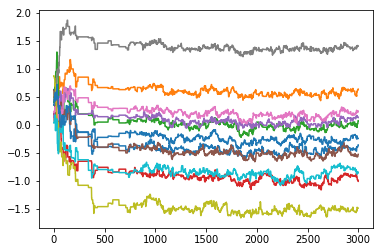

[-0.45019847  0.57583917 -0.02120413 -0.96680557  0.05212617 -0.50896524
  0.18729251  1.3646763  -1.51809765 -0.85865396 -0.25693311]
[-0.49672965  0.55363514 -0.03839992 -0.9881996  -0.06548371 -0.51429656
  0.15546027  1.41985072 -1.6038735  -0.97089449 -0.25699837]


In [18]:
plt.plot(alpha_stor.T)
plt.show()
print(np.mean(alpha_stor[:,1000:],axis= 1))
print(a_true)

0.030000000000000013

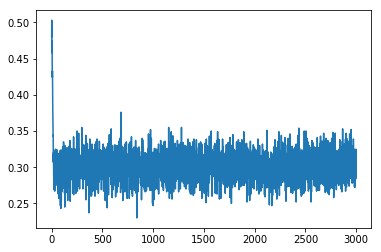

In [19]:
plt.plot(acc_stor[0,:].T)
rho_a

# Simulation study: 

In [114]:
from  tqdm import tqdm
## Building a sampler: 
reps = 12000
n_chains = 3
#N = df.user.nunique()
#K = X_t.shape[1]
#J = df.c_index_h.nunique()

trim = 1
#starting values:
b_c = np.zeros((n_chains, K_b))

b_start = [10,0,-10]
for i in range(n_chains):
    b_c[i,:] = np.ones(K_b)*b_start[i]

alpha_c = np.zeros((n_chains,K_a))
alpha_start = [10,0,-10]
for i in range(n_chains):
    alpha_c[i,:] = np.ones(K_a)*alpha_start[i]
#alpha = a_true
#b = b_stor[-1,:]
#b = b_true

W_start = [10,5,1]
W_c = np.zeros((n_chains,K_b,K_b))  #np.array([[2,1,1],[1,2,1],[1,1,2]])*100

for i in range(n_chains):
    W_c[i,:,:] = np.identity(K_b)*W_start[i]

#W = B
#W[np.triu_indices(5)]=W_stor[-1,:]
#W[np.tril_indices(5)]=W_stor[-1,:]

beta_N_c = np.zeros((n_chains,N,K_b))
for i in range(n_chains): 
    beta_N_c[i,:,:] = np.random.multivariate_normal(b_c[i,:], W_c[i,:,:], size = N)


#beta_N = beta_stor[:,:,-1]


# 
acc_rate_g = 0.3
rho_b = .5
rho_a = 0.1
F_a, F_b, a_upd = None, None, 1

# Disabling parts of the sampler
#beta_N = coeff
#b = b_true
#W = B
#beta_N = coeff
# Sampling:
b_stor = np.zeros((n_chains,int(reps/trim)+1,K_b))
W_stor = np.zeros((n_chains,int(reps/trim)+1,sum(range(K_b+1))))
beta_stor = np.zeros((n_chains,N,K_b,int(reps/trim)+1))
alpha_stor = np.zeros((n_chains,K_a,int(reps/trim)+1))
acc_stor = np.zeros((n_chains,2,int(reps/trim)+1))

for i in range(n_chains):
    beta_N = beta_N_c[i,:,:]
    b = b_c[i,:]
    W = W_c[i,:,:]
    alpha = alpha_c[i,:]
    
    beta_stor[i,:,:,0] = beta_N
    b_stor[i,0,:] = b
    W_stor[i,0,:] = W[np.triu_indices(K_b)]
    alpha_stor[i,:,0] = alpha
    
    
    for t in tqdm_notebook(range(reps)):

        #print(beta_N.shape)
        b_mean = np.mean(beta_N, axis=0)
        #print(b_mean.shape)

        b = b_posterior(b_mean, W/N)
        #print(b)

        W = posterior_W_v2(b, beta_N)
        #print(W)
        beta_N, acc_rate_b, F_b = metropolis_step_beta(X_t, y_index, y_nindex, alpha, beta_N, b, W, rho_b, users, N,NT, J,t_max, index, F_b, a_upd)

        alpha, acc_rate_a, a_upd = metropolis_step_alpha(X_t, y_index, y_nindex, alpha, beta_N, rho_a, users, N, NT, J, t_max, index, F_a)




        # Storing the values
        if t % trim == 0:
            b_stor[i,int(t/trim)+1] = b
            W_stor[i,int(t/trim)+1] = W[np.triu_indices(K_b)]
            beta_stor[i,:,:,int(t/trim)+1] = beta_N
            alpha_stor[i,:,int(t/trim)+1] = alpha
            acc_stor[i,:,int(t/trim)+1] = acc_rate_b, acc_rate_a


        # Updating the acc_rate
        if acc_rate_b < acc_rate_g:
            rho_b = rho_b - 0.02 #(acc_rate - acc_rate_g)
        if acc_rate_b > acc_rate_g:
            rho_b = rho_b + 0.02 #(acc_rate - acc_rate_g)

        # updating after 100 iterations:
        if t % 100 == 0: 
            eva = np.mean(acc_stor[i,1,t-100:t])
            print(eva, rho_a)
            if eva < acc_rate_g:
                rho_a = rho_a - 0.005#*(eva - acc_rate_g)/acc_rate_g
            if eva > acc_rate_g:
                rho_a = rho_a + 0.005#*(eva - acc_rate_g)/acc_rate_g #(acc_rate - acc_rate_g)
        

    #print(beta_N[n,:])

        

    

HBox(children=(IntProgress(value=0, max=12000), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan 0.1
0.3 0.1
0.22 0.1
0.29 0.095
0.09 0.09
0.22 0.08499999999999999
0.24 0.07999999999999999
0.18 0.07499999999999998
0.27 0.06999999999999998
0.26 0.06499999999999997
0.23 0.05999999999999998
0.19 0.05499999999999998
0.27 0.04999999999999998
0.28 0.044999999999999984
0.41 0.03999999999999999
0.29 0.044999999999999984
0.41 0.03999999999999999
0.32 0.044999999999999984
0.33 0.04999999999999998
0.33 0.05499999999999998
0.26 0.05999999999999998
0.3 0.05499999999999998
0.26 0.05499999999999998
0.19 0.04999999999999998
0.28 0.044999999999999984
0.27 0.03999999999999999
0.24 0.03499999999999999
0.26 0.02999999999999999
0.31 0.024999999999999988
0.21 0.02999999999999999
0.36 0.024999999999999988
0.21 0.02999999999999999
0.33 0.024999999999999988
0.26 0.02999999999999999
0.25 0.024999999999999988
0.47 0.019999999999999987
0.36 0.024999999999999988
0.21 0.02999999999999999
0.3 0.024999999999999988
0.31 0.024999999999999988
0.17 0.02999999999999999
0.37 0.024999999999999988
0.25 0.02999999999

HBox(children=(IntProgress(value=0, max=12000), HTML(value='')))

nan 0.024999999999999988
0.39 0.024999999999999988
0.42 0.02999999999999999
0.31 0.03499999999999999
0.21 0.03999999999999999
0.26 0.03499999999999999
0.24 0.02999999999999999
0.32 0.024999999999999988
0.24 0.02999999999999999
0.33 0.024999999999999988
0.32 0.02999999999999999
0.26 0.03499999999999999
0.21 0.02999999999999999
0.4 0.024999999999999988
0.25 0.02999999999999999
0.35 0.024999999999999988
0.3 0.02999999999999999
0.27 0.02999999999999999
0.38 0.024999999999999988
0.32 0.02999999999999999
0.18 0.03499999999999999
0.28 0.02999999999999999
0.37 0.024999999999999988
0.24 0.02999999999999999
0.3 0.024999999999999988
0.3 0.024999999999999988
0.3 0.024999999999999988
0.33 0.024999999999999988
0.26 0.02999999999999999
0.41 0.024999999999999988
0.2 0.02999999999999999
0.34 0.024999999999999988
0.3 0.02999999999999999
0.3 0.02999999999999999
0.16 0.02999999999999999
0.29 0.024999999999999988
0.37 0.019999999999999987
0.37 0.024999999999999988
0.25 0.02999999999999999
0.36 0.0249999999

HBox(children=(IntProgress(value=0, max=12000), HTML(value='')))

nan 0.02999999999999999
0.54 0.02999999999999999
0.44 0.03499999999999999
0.53 0.03999999999999999
0.52 0.044999999999999984
0.5 0.04999999999999998
0.53 0.05499999999999998
0.44 0.05999999999999998
0.43 0.06499999999999997
0.5 0.06999999999999998
0.43 0.07499999999999998
0.4 0.07999999999999999
0.48 0.08499999999999999
0.35 0.09
0.26 0.095
0.2 0.09
0.15 0.08499999999999999
0.12 0.07999999999999999
0.11 0.07499999999999998
0.06 0.06999999999999998
0.05 0.06499999999999997
0.05 0.05999999999999998
0.05 0.05499999999999998
0.04 0.04999999999999998
0.1 0.044999999999999984
0.16 0.03999999999999999
0.19 0.03499999999999999
0.3 0.02999999999999999
0.32 0.02999999999999999
0.22 0.03499999999999999
0.22 0.02999999999999999
0.33 0.024999999999999988
0.3 0.02999999999999999
0.25 0.02999999999999999
0.32 0.024999999999999988
0.26 0.02999999999999999
0.38 0.024999999999999988
0.3 0.02999999999999999
0.24 0.02999999999999999
0.25 0.024999999999999988
0.41 0.019999999999999987
0.41 0.02499999999999

In [156]:
plot(alpha_stor[j,i,:])

NameError: name 'plot' is not defined

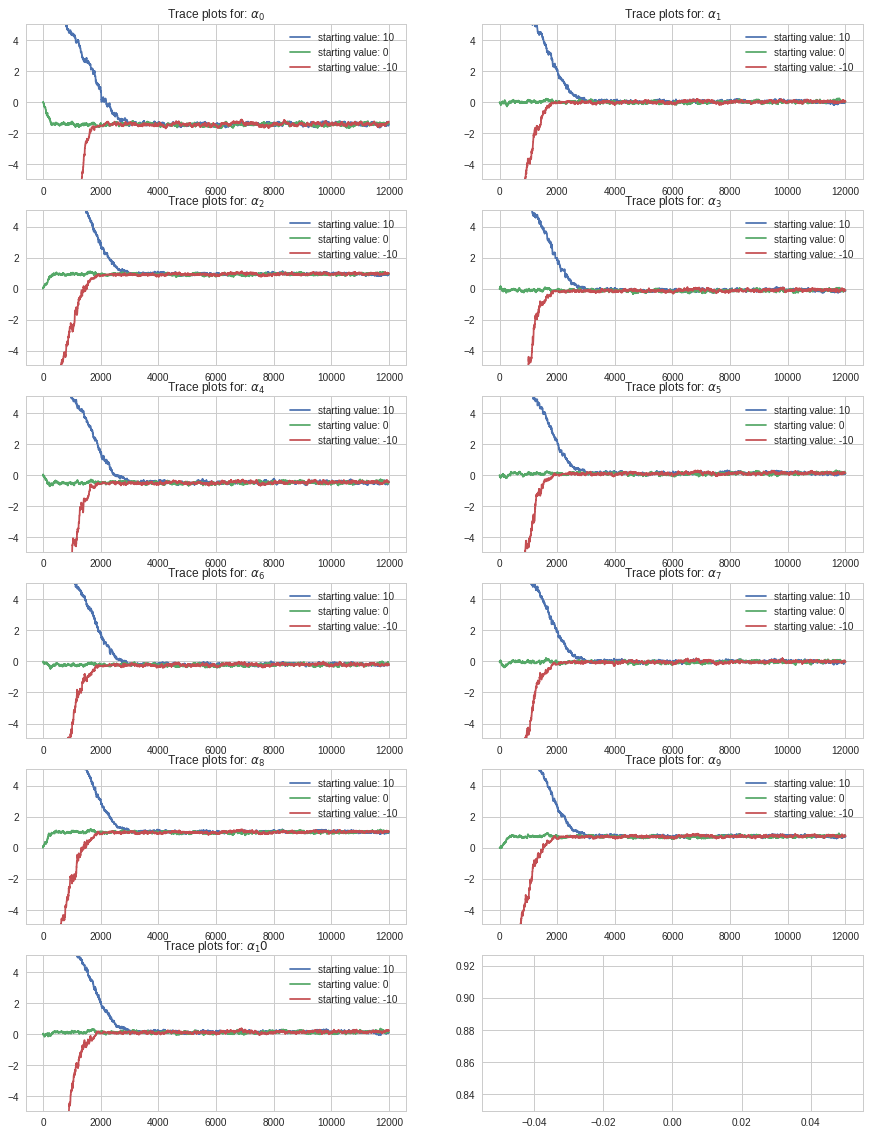

In [310]:
fig, ax = plt.subplots(6,2,figsize=(15,20))
ax = ax.flatten()
for i in range(K_a):
    for j in range(n_chains):
        label = 'starting value: ' + str(alpha_start[j])
        ax[i].plot(alpha_stor[j,i,:], label = label)
        
    plt.plot(a_true[2], color = 'Red')
    mean=alpha_stor[:,:,4000:].mean()
    ax[i].set_ylim([mean-5, mean+5])
    ax[i].legend()
    ax[i].set_title('Trace plots for: ' + r'$\alpha_{}$'.format(i))
    
#plt.ylim([-2,2])

plt.savefig('alpha_sim_study.png', bbox_inches = 'tight', dpi=150 )

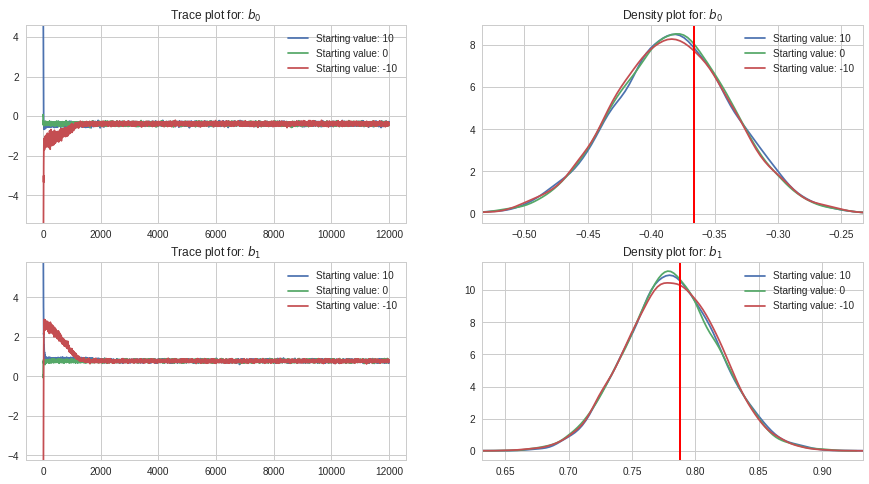

In [308]:
import seaborn as sns
sns.set_style('whitegrid')

fig, ax = plt.subplots(2,2,figsize=(15,8))
ax = ax.flatten()
for i in range(K_b):
    for j in range(n_chains):
        label = 'Starting value: ' + str(b_start[j])
        ax[i*2].plot(b_stor[j,:,i], label = label)
        sns.kdeplot(b_stor[j,4000:,i],label = label, ax = ax[i*2+1])
        ax[i*2+1].axvline(x=[b_true[i]], color = 'red')
        

        
        
    plt.plot(a_true[2], color = 'Red')
    mean=b_stor[:,4000:,i].mean()
    ax[i*2].set_ylim([mean-5, mean+5])
    ax[i*2].legend()
    ax[i*2+1].legend()
    ax[i*2+1].set_xlim([mean-0.15, mean+0.15])


    ax[i*2].set_title('Trace plot for: ' + r'$b_{}$'.format(i))
    ax[i*2+1].set_title('Density plot for: ' + r'$b_{}$'.format(i))
    
plt.savefig('b_sim_study.png', bbox_inches = 'tight', dpi = 400)
    
#plt.ylim([-2,2])

### Covariance matrix

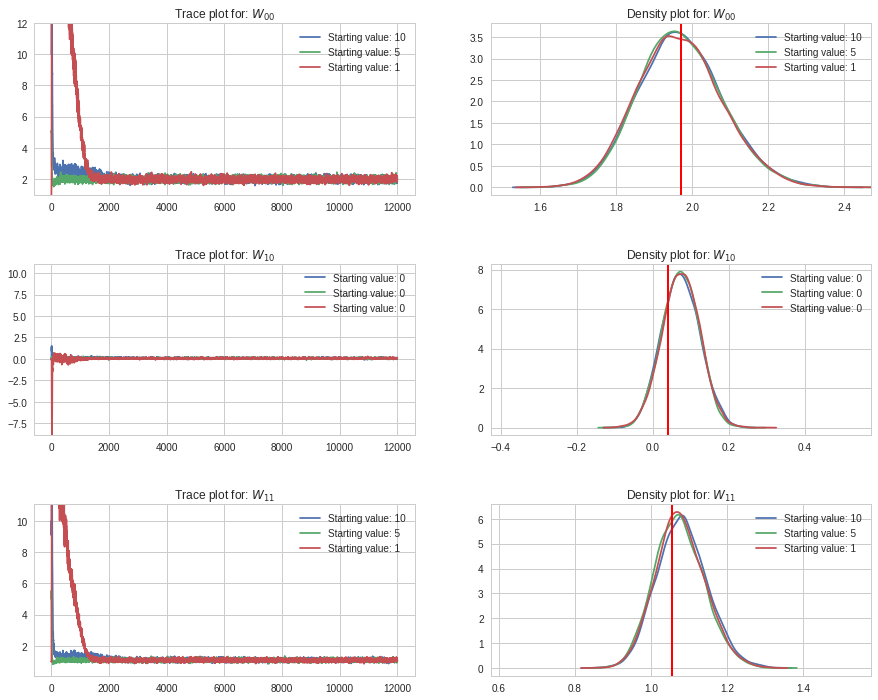

In [309]:

fig, ax = plt.subplots(3,2,figsize=(15,12))
ax = ax.flatten()

lab=[r'$W_{00}$',r'$W_{10}$',r'$W_{11}$']
for i in range(3):
    for j in range(n_chains):
        label = 'Starting value: ' + str(W_start[j])
        if i != 1:
            ax[i*2].plot(W_stor[j,:,i], label = label)
            sns.kdeplot(W_stor[j,4000:,i],label = label, ax = ax[i*2+1])
        else:
            label = 'Starting value: ' + str(0)
            ax[i*2].plot(W_stor[j,:,i], label = label)
            sns.kdeplot(W_stor[j,4000:,i],label = label, ax = ax[i*2+1])
            
        ax[i*2+1].axvline(x=W[np.triu_indices(2)][i], color = 'red')
        

        
        
    plt.plot(a_true[2], color = 'Red')
    mean=W_stor[:,4000:,i].mean()
    ax[i*2].set_ylim([mean-1, mean+10])
    ax[2].set_ylim([mean-10, mean+10])

    ax[i*2].legend()
    ax[i*2+1].legend()
    ax[i*2+1].set_xlim([mean-0.5, mean+0.5])
    

    ax[i*2].set_title('Trace plot for: ' + lab[i])
    ax[i*2+1].set_title('Density plot for: ' + lab[i])
    
plt.subplots_adjust(hspace=0.4)

    #plt.ylim([-2,2])
    
plt.savefig('W_sim_study.png', bbox_inches = 'tight', dpi=400 )

### Constructing a table with true values

In [276]:
b_stor.shape

(3, 12001, 2)

In [283]:
W_stor.shape

(3, 12001, 3)

In [290]:
a_true

array([-1.47665897, -0.01268428,  0.87800642, -0.11449945, -0.51567998,
        0.03768933, -0.28280583, -0.12536657,  0.8912959 ,  0.66079362,
        0.07782057])

In [296]:
alpha_stor.std()

2.1013439624271144

In [297]:
from pylatex import Document, LongTabu, Tabularx, Tabular, LongTable, HFill, Section, MultiColumn
from pylatex.utils import bold
def generate_longtabu():
    geometry_options = {
        "landscape": True,
        "margin": "0.5in",
        "headheight": "20pt",
        "headsep": "10pt",
        "includeheadfoot": True
    }
    doc = Section(title = "table")

    # Generate data table
    with doc.create(Tabular("l c c c, c")) as data_table:
        header_row1 = ["","Est.","True","Bias","std."]
        data_table.add_row(header_row1)#,mapper=[bold])
        
        header_row1 = ["Mean:","","","",""]
        data_table.add_row(header_row1)#,mapper=[bold])

        for i in range(b_stor.shape[-1]):
            Est = np.around(b_stor[:,4000:,i].mean(),3)
            bias = np.around(Est - b_true[i],3)
            std = np.around(b_stor[:,4000:,i].std(),3)
        
            header_row1 = ["$b_{}$".format(i),Est,np.around(b_true[i],3), bias, std]
            data_table.add_row(header_row1)#,mapper=[bold])
        

        data_table.add_empty_row()
        
        header_row1 = ["Variance:","","","",""]
        var=["$W_{00}$","$W_{10}$","$W_{11}$"]
        for i in range(W_stor.shape[-1]):
            Est = np.around(W_stor[:,4000:,i].mean(),3)
            bias = np.around(Est - W[np.triu_indices(2)][i], 3)
            std = np.around(W_stor[:,4000:,i].std(),3)
        
            header_row1 = [var[i],Est,np.around(W[np.triu_indices(2)][i], 3), bias, std]
            data_table.add_row(header_row1)#,mapper=[bold])

        header_row1 = ["ASC's:","","","",""]
        for i in range(alpha_stor.shape[1]):
            Est = np.around(alpha_stor[:,i,4000:].mean(), 3)
            bias = np.around(Est - a_true[i], 3)
            std = np.around(alpha_stor[:,i,4000:].std(), 3)

        
            header_row1 = [r"$\alpha_{}$".format(i), Est, np.around(a_true[i],3), bias,std]
            data_table.add_row(header_row1)#,mapper=[bold])

        
        

    doc.generate_tex("sim_table")

generate_longtabu()
